
Running scenario: Sunny

Running scenario: Cloudy

Running scenario: Rainy

==================== WEATHER SCENARIO RESULTS ====================
            LFR (%)        PVUR (%)         GDR (%)         SSR (%)       
Controller Baseline  Fuzzy Baseline  Fuzzy Baseline  Fuzzy Baseline  Fuzzy
Weather                                                                   
Cloudy        100.0  100.0    63.34  63.34     9.53   9.57    90.47  90.43
Rainy         100.0  100.0    98.95  98.95    48.77  48.84    51.23  51.16
Sunny         100.0  100.0    38.68  38.68     1.23   1.25    98.77  98.75

KPI summary saved to: /Users/freshliannes.rosal/Documents/Stat Client/Tomie/weather_kpi_summary.csv


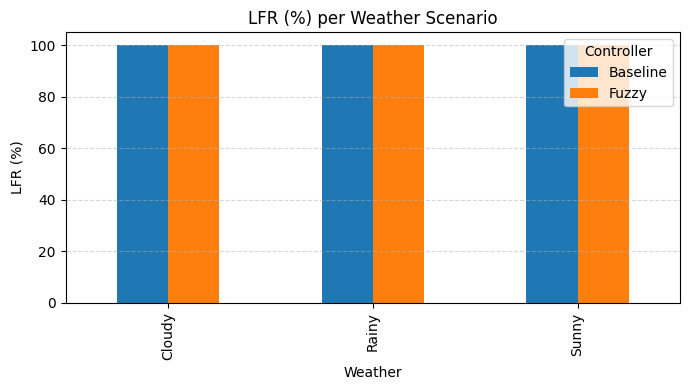

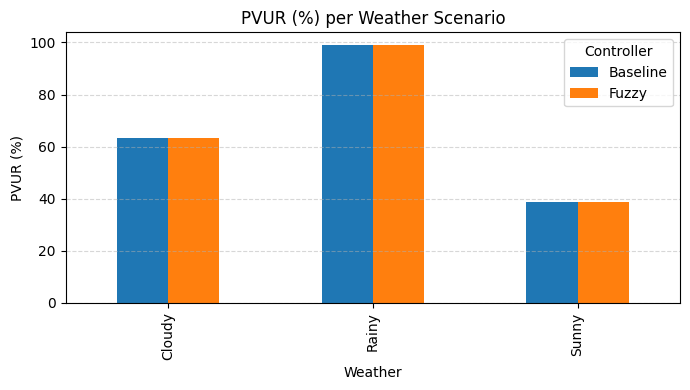

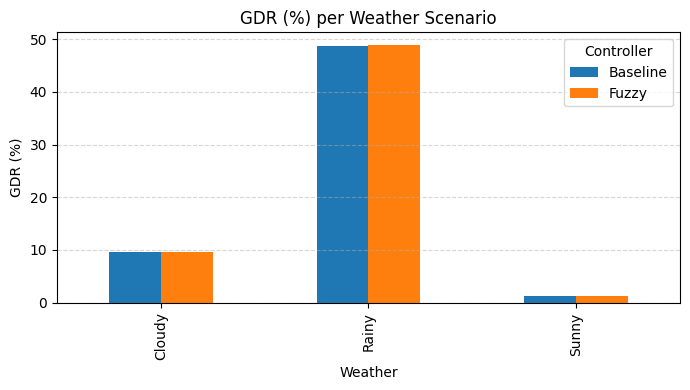

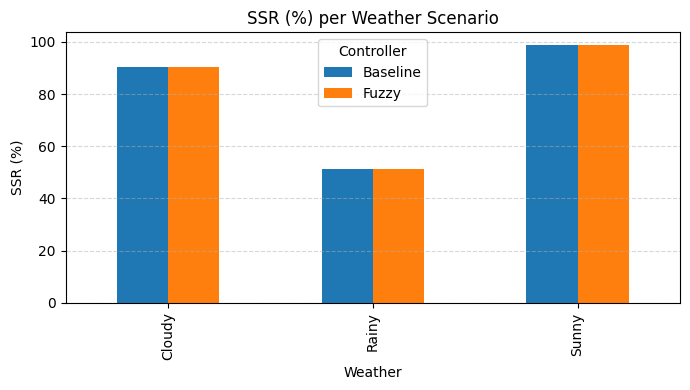

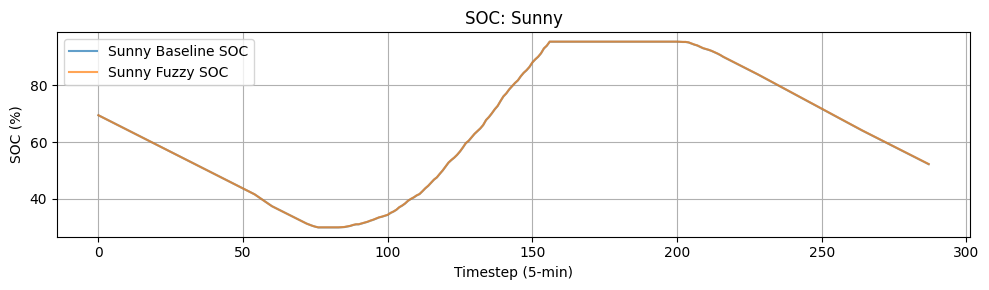

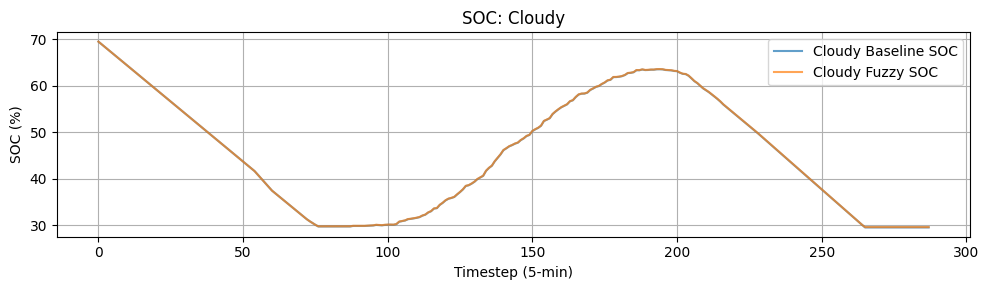

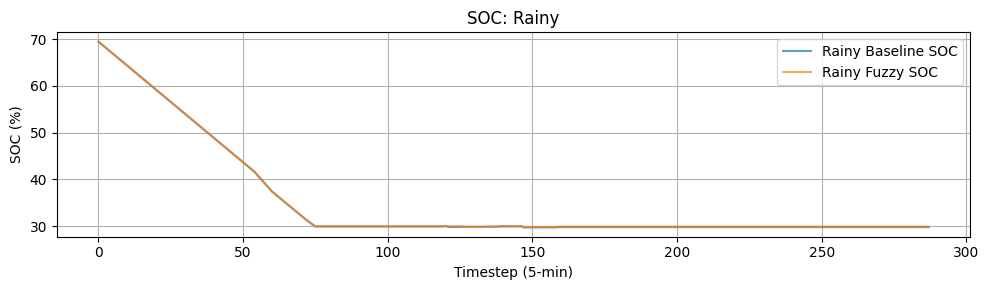

In [17]:
"""
soc_aware_fuzzy_simulation.py

Full integrated simulation:
- Baseline controller (PV -> Battery -> Grid)
- SOC-aware fuzzy controller (Mamdani)
- Multi-weather scenarios (Sunny, Cloudy, Rainy)
- KPI computation, console table, CSV export
- Plots: SOC, Energy distribution, KPI per scenario

Author: Engr. Jamie Eduardo Rosal
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# ---------------------------
# Constants
# ---------------------------
DT_MIN = 5
STEPS_PER_DAY = int(24 * 60 / DT_MIN)

SOC_MIN = 0.30
SOC_MAX = 0.95
BAT_EFF = 0.92

ARCHETYPES = {
    '6kW': {'p_pv_kw': 6.0, 'bat_kwh': 20.0, 'inv_kw': 6.0},
}

PV_PEAK_IRRADIANCE = 1200.0
PV_PANEL_EFF = 0.18
SYSTEM_LOSSES = 0.15

# ---------------------------
# Synthetic profiles generator
# ---------------------------
def generate_profiles(days=1, seed=42):
    np.random.seed(seed)
    steps = days * STEPS_PER_DAY
    t = np.arange(steps)
    hour_frac = (t % STEPS_PER_DAY) / STEPS_PER_DAY * 24

    # smooth daily irradiance shape + randomness
    irradiance = np.maximum(0, np.sin((hour_frac - 6)/12 * np.pi))
    irradiance *= (0.6 + 0.4 * np.random.rand(steps))
    irradiance_w = irradiance * PV_PEAK_IRRADIANCE

    # loads (example household)
    fridge = np.clip(900 + 200 * np.random.randn(steps) * 0.02, 700, 1200)
    lights = np.where((hour_frac >= 18) | (hour_frac < 6), 150, 30)
    router = 20
    critical = fridge + lights + router

    pc = np.where((hour_frac >= 8) & (hour_frac <= 18), 200, 20)
    fan = np.where((hour_frac >= 12) & (hour_frac <= 18), 100, 40)
    essential = pc + fan

    tv = np.where((hour_frac >= 19) & (hour_frac <= 22), 80, 10)
    washer = np.zeros(steps)
    wash_start = np.random.choice(range(steps), size=max(1,int(0.02*steps)), replace=False)
    for s in wash_start:
        washer[s:s+6] += 400
    nonessential = tv + washer

    total = critical + essential + nonessential

    return pd.DataFrame({
        'irradiance_wm2': irradiance_w,
        'critical_load_w': critical,
        'essential_load_w': essential,
        'nonessential_load_w': nonessential,
        'total_load_w': total
    })

# ---------------------------
# PV model
# ---------------------------
def pv_power_from_irradiance(irradiance_wm2, p_pv_kw, panel_eff=PV_PANEL_EFF, losses=SYSTEM_LOSSES):
    p_rated_w = p_pv_kw * 1000.0
    panel_area = p_rated_w / (panel_eff * 1000.0)
    p_dc = irradiance_wm2 * panel_area * panel_eff
    p_ac = p_dc * (1 - losses)
    return np.maximum(0.0, p_ac)

# ---------------------------
# Battery model
# ---------------------------
class Battery:
    def __init__(self, capacity_kwh, soc_init=0.7):
        self.capacity_kwh = capacity_kwh
        self.soc = soc_init

    def charge(self, energy_wh):
        """energy_wh added to battery (Wh) — already accounts for efficiency externally if desired."""
        cap_wh = self.capacity_kwh * 1000.0
        self.soc = min(1.0, self.soc + energy_wh / cap_wh)

    def discharge(self, energy_wh):
        cap_wh = self.capacity_kwh * 1000.0
        self.soc = max(0.0, self.soc - energy_wh / cap_wh)

# ---------------------------
# Baseline controller (single step)
# ---------------------------
def baseline_controller_step(pv_avail_w, load_w, battery: Battery, inv_max_w):
    pv_to_load = min(pv_avail_w, load_w)
    remainder = load_w - pv_to_load
    pv_surplus = max(0.0, pv_avail_w - pv_to_load)

    charged_to_batt_w = 0.0
    if battery.soc < SOC_MAX and pv_surplus > 0:
        charge_power = min(pv_surplus, inv_max_w)
        charged_to_batt_w = charge_power

    discharged_from_batt_w = 0.0
    imported_from_grid_w = 0.0
    if remainder > 0:
        if battery.soc > SOC_MIN:
            discharge_power = min(remainder, inv_max_w)
            discharged_from_batt_w = discharge_power
            remainder -= discharge_power
        if remainder > 0:
            imported_from_grid_w = remainder

    # standardize returned names so downstream code is consistent
    return {
        'pv_to_load_w': pv_to_load,
        'batt_to_load_w': discharged_from_batt_w,
        'grid_to_load_w': imported_from_grid_w,
        'pv_surplus_w': pv_surplus,
        'charged_to_batt_w': charged_to_batt_w,
    }

# ---------------------------
# Build fuzzy controller
# ---------------------------
def build_fuzzy_controller():
    soc = ctrl.Antecedent(np.arange(0, 101, 1), 'soc')
    pv = ctrl.Antecedent(np.arange(0, int(PV_PEAK_IRRADIANCE)+1, 1), 'pv')
    tod = ctrl.Antecedent(np.arange(0, 24.1, 1), 'tod')
    priority = ctrl.Consequent(np.arange(0, 11, 1), 'priority')

    soc['low'] = fuzz.trapmf(soc.universe, [0,0,20,40])
    soc['mid'] = fuzz.trimf(soc.universe, [30,50,70])
    soc['high'] = fuzz.trapmf(soc.universe, [60,80,100,100])

    pv['poor'] = fuzz.trapmf(pv.universe, [0,0,200,400])
    pv['fair'] = fuzz.trimf(pv.universe, [200,500,800])
    pv['good'] = fuzz.trapmf(pv.universe, [600,800,PV_PEAK_IRRADIANCE,PV_PEAK_IRRADIANCE])

    tod['night'] = fuzz.trapmf(tod.universe, [0,0,6,6])
    tod['day'] = fuzz.trapmf(tod.universe, [6,6,18,18])
    tod['dusk'] = fuzz.trapmf(tod.universe, [16,18,20,20])

    priority['very_low'] = fuzz.trapmf(priority.universe, [0,0,2,4])
    priority['low'] = fuzz.trimf(priority.universe, [3,4,5])
    priority['medium'] = fuzz.trimf(priority.universe, [4,5,6])
    priority['high'] = fuzz.trimf(priority.universe, [5,6,7])
    priority['very_high'] = fuzz.trapmf(priority.universe, [6,8,10,10])

    rules = [
        ctrl.Rule(soc['high'] & pv['good'], priority['very_high']),
        ctrl.Rule(soc['mid'] & pv['fair'], priority['high']),
        ctrl.Rule(soc['low'] & pv['poor'], priority['low']),
        ctrl.Rule(tod['night'] & soc['low'], priority['very_low']),
        ctrl.Rule(tod['day'] & pv['good'], priority['very_high']),
        ctrl.Rule(pv['poor'] & soc['mid'], priority['medium']),
    ]

    system = ctrl.ControlSystem(rules)
    sim = ctrl.ControlSystemSimulation(system)
    return sim

# ---------------------------
# Allocation by priority (fuzzy)
# ---------------------------
def allocate_power_by_priority(pv_avail_w, battery, inv_max_w, cat_demands, priority_scores):
    # ensure deterministic order: highest priority first
    cats = sorted(cat_demands.keys(), key=lambda k: priority_scores[k], reverse=True)
    pv_remaining = pv_avail_w
    inv_limit = inv_max_w
    flows = {k: {'pv':0.0,'batt':0.0,'grid':0.0} for k in cat_demands}

    # 1. PV allocation
    for k in cats:
        demand = cat_demands[k]
        if demand <= 0: continue
        pv_to_cat = min(pv_remaining, demand, inv_limit)
        flows[k]['pv'] += pv_to_cat
        pv_remaining -= pv_to_cat

    # 2. Battery allocation (discharge) by priority
    for k in cats:
        demand = cat_demands[k] - flows[k]['pv']
        if demand <= 0: continue
        if battery.soc > SOC_MIN:
            batt_to_cat = min(demand, inv_limit)
            flows[k]['batt'] += batt_to_cat
            # update battery SOC (convert W over DT to Wh and apply round-trip)
            battery.discharge(batt_to_cat * (DT_MIN/60.0) / BAT_EFF)
            demand -= batt_to_cat

        if demand > 0:
            flows[k]['grid'] += demand

    pv_surplus = max(0.0, pv_remaining)
    # 3. Charge battery with PV surplus if capacity
    if pv_surplus > 0 and battery.soc < SOC_MAX:
        charge_power = min(pv_surplus, inv_limit)
        battery.charge(charge_power * (DT_MIN/60.0) * BAT_EFF)
        pv_surplus -= charge_power

    totals = {
        'pv_to_load_w': sum(flows[k]['pv'] for k in flows),
        'batt_to_load_w': sum(flows[k]['batt'] for k in flows),
        'grid_to_load_w': sum(flows[k]['grid'] for k in flows),
        'pv_surplus_w': pv_surplus,
        'soc': battery.soc
    }
    return totals

# ---------------------------
# Run single simulation
# ---------------------------
def run_simulation(df_profile, archetype_key='6kW', controller='fuzzy'):
    arch = ARCHETYPES[archetype_key]
    p_pv_kw = arch['p_pv_kw']
    inv_kw = arch['inv_kw']
    batt_kwh = arch['bat_kwh']

    battery = Battery(capacity_kwh=batt_kwh, soc_init=0.7)
    fuzzy_sim = build_fuzzy_controller() if controller == 'fuzzy' else None

    logs = []
    for i, row in df_profile.iterrows():
        pv_ac_w = min(pv_power_from_irradiance(row['irradiance_wm2'], p_pv_kw), inv_kw*1000.0)
        cat_demands = {
            'critical': row['critical_load_w'],
            'essential': row['essential_load_w'],
            'non_essential': row['nonessential_load_w']
        }

        if controller == 'baseline':
            total_load = row['total_load_w']
            res = baseline_controller_step(pv_ac_w, total_load, battery, inv_kw*1000.0)
            # account for baseline charged_to_batt (available in returned field) -> convert to Wh then store with eff
            if 'charged_to_batt_w' in res and res['charged_to_batt_w'] > 0:
                battery.charge(res['charged_to_batt_w'] * (DT_MIN/60.0) * BAT_EFF)
            # discharged energy already handled in res by naming batt_to_load_w (we must reflect Wh change)
            if res.get('batt_to_load_w',0) > 0:
                battery.discharge(res['batt_to_load_w'] * (DT_MIN/60.0) / BAT_EFF)
            res['soc'] = battery.soc
            logs.append(res)
        else:
            # fuzzy controller
            soc_percent = battery.soc * 100.0
            hour = ((i % STEPS_PER_DAY) / STEPS_PER_DAY) * 24.0
            # provide inputs safely
            try:
                fuzzy_sim.input['soc'] = soc_percent
                fuzzy_sim.input['pv'] = row['irradiance_wm2']
                fuzzy_sim.input['tod'] = hour
                fuzzy_sim.compute()
                pscore = float(fuzzy_sim.output['priority'])
            except Exception:
                pscore = 5.0
            priorities = {'critical': min(10.0, pscore + 2.0),
                          'essential': pscore,
                          'non_essential': max(0.0, pscore - 2.0)}
            totals = allocate_power_by_priority(pv_ac_w, battery, inv_kw*1000.0, cat_demands, priorities)
            logs.append(totals)

    df_logs = pd.DataFrame(logs)
    # ensure columns exist for downstream KPI code
    for c in ['pv_to_load_w','batt_to_load_w','grid_to_load_w','pv_surplus_w','soc']:
        if c not in df_logs:
            df_logs[c] = 0.0
    return df_logs

# ---------------------------
# KPI computation (robust)
# ---------------------------
def compute_kpis(df_profile, kpi_df):
    dt_hr = DT_MIN / 60.0
    def safe_sum(df, col):
        return df[col].sum() if col in df and not df[col].isnull().all() else 0.0

    E_demand = df_profile['total_load_w'].sum() * dt_hr
    E_pv_avail = pv_power_from_irradiance(df_profile['irradiance_wm2'], ARCHETYPES['6kW']['p_pv_kw']).sum() * dt_hr

    E_pv_used = safe_sum(kpi_df, 'pv_to_load_w') * dt_hr
    E_batt_dis = safe_sum(kpi_df, 'batt_to_load_w') * dt_hr
    E_grid = safe_sum(kpi_df, 'grid_to_load_w') * dt_hr
    E_batt_chg = safe_sum(kpi_df, 'pv_surplus_w') * dt_hr  # approximate PV->battery
    E_served = (E_pv_used + E_batt_dis + E_grid)

    LFR = 100.0 * E_served / E_demand if E_demand > 0 else 0.0
    PVUR = 100.0 * E_pv_used / E_pv_avail if E_pv_avail > 0 else 0.0
    GDR = 100.0 * E_grid / E_demand if E_demand > 0 else 0.0
    EENS = E_demand - E_served
    PVW = max(0.0, E_pv_avail - E_pv_used)
    BUE = 100.0 * (E_batt_dis / E_batt_chg) if E_batt_chg > 0 else 0.0
    SOCavg = kpi_df['soc'].mean() * 100.0 if 'soc' in kpi_df else 0.0
    SOCstd = kpi_df['soc'].std() * 100.0 if 'soc' in kpi_df else 0.0
    SSR = 100.0 - GDR
    PVR = 0.0  # placeholder; compute if per-category served/unmet logging implemented

    return {
        'LFR (%)': LFR,
        'PVUR (%)': PVUR,
        'GDR (%)': GDR,
        'EENS (Wh)': EENS,
        'PV Wastage (Wh)': PVW,
        'BUE (%)': BUE,
        'SOCavg (%)': SOCavg,
        'SOCstd (%)': SOCstd,
        'SSR (%)': SSR,
        'PVR (%)': PVR
    }

# ---------------------------
# Weather scenario generator
# ---------------------------
def generate_weather_profiles(days=1):
    base = generate_profiles(days=days)
    profiles = {}
    rng = np.random.RandomState(123)
    # Sunny: mild positive multiplier
    profiles['Sunny'] = base.copy()
    profiles['Sunny']['irradiance_wm2'] = base['irradiance_wm2'] * rng.uniform(0.9, 1.0, len(base))
    # Cloudy: moderate
    profiles['Cloudy'] = base.copy()
    profiles['Cloudy']['irradiance_wm2'] = base['irradiance_wm2'] * rng.uniform(0.4, 0.7, len(base))
    # Rainy: low
    profiles['Rainy'] = base.copy()
    profiles['Rainy']['irradiance_wm2'] = base['irradiance_wm2'] * rng.uniform(0.1, 0.3, len(base))
    return profiles

# ---------------------------
# Multi-weather runner + plots + csv export
# ---------------------------
def run_weather_scenarios(days=1, archetype='6kW', export_csv=True):
    weather_data = generate_weather_profiles(days=days)
    results = []
    all_logs = {}

    for weather, df in weather_data.items():
        print(f"\nRunning scenario: {weather}")
        kpi_base = run_simulation(df, archetype_key=archetype, controller='baseline')
        kpi_fuzzy = run_simulation(df, archetype_key=archetype, controller='fuzzy')

        # normalize columns (baseline already returns standardized names but keep safe)
        if 'discharged_from_batt_w' in kpi_base:
            kpi_base = kpi_base.rename(columns={'discharged_from_batt_w':'batt_to_load_w'})
        if 'imported_from_grid_w' in kpi_base:
            kpi_base = kpi_base.rename(columns={'imported_from_grid_w':'grid_to_load_w'})

        base_kpis = compute_kpis(df, kpi_base)
        fuzzy_kpis = compute_kpis(df, kpi_fuzzy)

        results.append({'Weather':weather, 'Controller':'Baseline', **base_kpis})
        results.append({'Weather':weather, 'Controller':'Fuzzy', **fuzzy_kpis})

        all_logs[(weather,'Baseline')] = kpi_base
        all_logs[(weather,'Fuzzy')] = kpi_fuzzy

    df_results = pd.DataFrame(results)

    # Console table
    print("\n==================== WEATHER SCENARIO RESULTS ====================")
    summary = df_results.pivot(index='Weather', columns='Controller', values=['LFR (%)','PVUR (%)','GDR (%)','SSR (%)'])
    print(summary.round(2))
    print("==================================================================\n")

    # CSV export
    if export_csv:
        out_file = "weather_kpi_summary.csv"
        df_results.to_csv(out_file, index=False)
        print(f"KPI summary saved to: {os.path.abspath(out_file)}")

    # Plots: KPI per metric
    metrics = ['LFR (%)','PVUR (%)','GDR (%)','SSR (%)']
    for metric in metrics:
        plt.figure(figsize=(7,4))
        subset = df_results.pivot(index='Weather', columns='Controller', values=metric)
        subset.plot(kind='bar', ax=plt.gca())
        plt.title(f'{metric} per Weather Scenario')
        plt.ylabel(metric)
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    # Plot example: SOC time series for last run to inspect behavior (Sunny baseline vs fuzzy)
    # pick one weather to display SOC traces
    for weather in ['Sunny','Cloudy','Rainy']:
        base_log = all_logs[(weather,'Baseline')]
        fuzzy_log = all_logs[(weather,'Fuzzy')]
        plt.figure(figsize=(10,3))
        plt.plot(base_log['soc']*100, label=f'{weather} Baseline SOC', alpha=0.7)
        plt.plot(fuzzy_log['soc']*100, label=f'{weather} Fuzzy SOC', alpha=0.7)
        plt.ylabel('SOC (%)'); plt.xlabel('Timestep (5-min)'); plt.title(f'SOC: {weather}')
        plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    return df_results, all_logs

# ---------------------------
# MAIN
# ---------------------------
if __name__ == "__main__":
    # if using Jupyter, you can run: %matplotlib inline before this script cell
    df_results, all_logs = run_weather_scenarios(days=1, archetype='6kW', export_csv=True)



=== Running: Sunny ===
 baseline ...
 fuzzy adaptive ...

=== Running: Cloudy ===
 baseline ...
 fuzzy adaptive ...

=== Running: Rainy ===
 baseline ...
 fuzzy adaptive ...

Summary saved at: /Users/freshliannes.rosal/Documents/Stat Client/Tomie/results/weather_kpi_summary.csv

==================== WEATHER SCENARIO RESULTS ====================
            LFR (%)        PVUR (%)         GDR (%)        SSR (%)       
Controller Baseline  Fuzzy Baseline  Fuzzy Baseline Fuzzy Baseline  Fuzzy
Weather                                                                  
Cloudy        75.35  68.88    63.60  63.60      0.0   0.0    100.0  100.0
Rainy         34.55  28.14    98.13  98.13      0.0   0.0    100.0  100.0
Sunny         93.47  73.79    39.75  39.75      0.0   0.0    100.0  100.0



<Figure size 700x400 with 0 Axes>

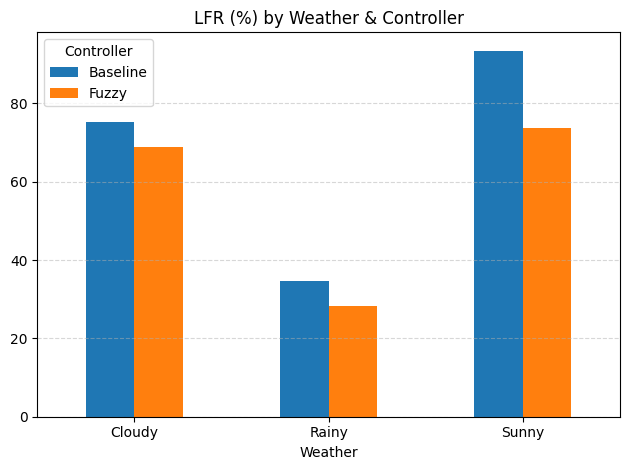

<Figure size 700x400 with 0 Axes>

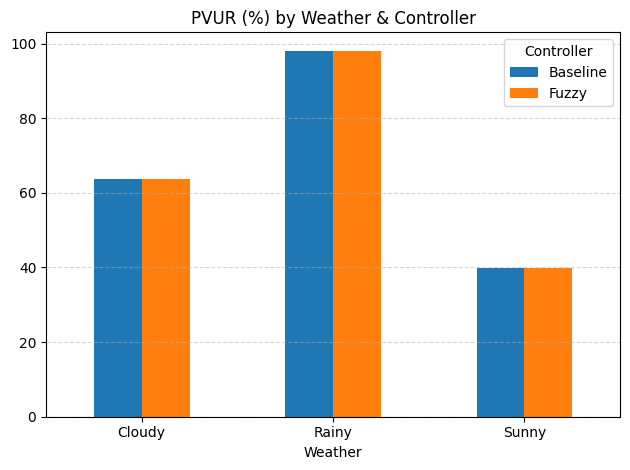

<Figure size 700x400 with 0 Axes>

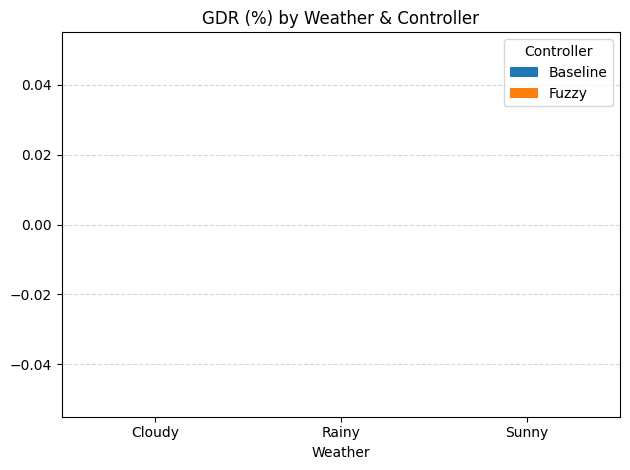

<Figure size 700x400 with 0 Axes>

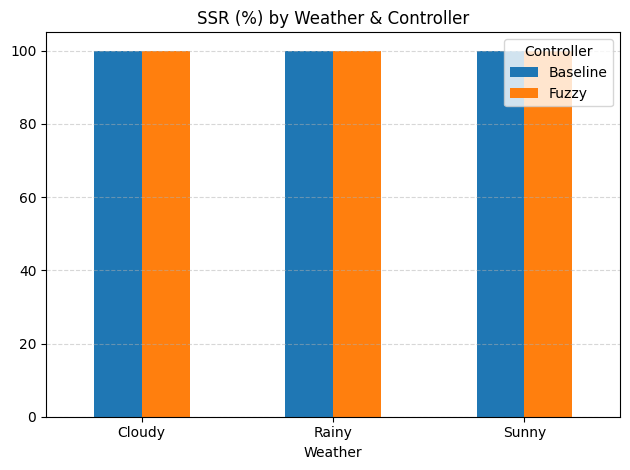

<Figure size 700x400 with 0 Axes>

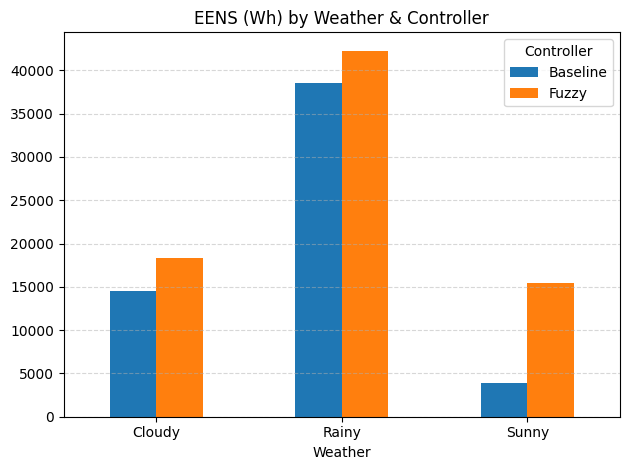

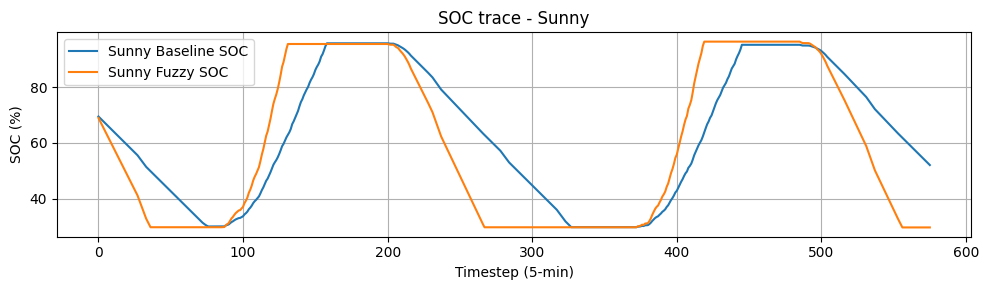

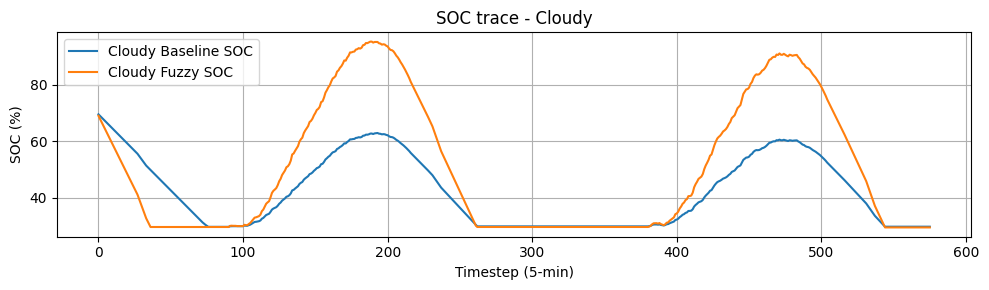

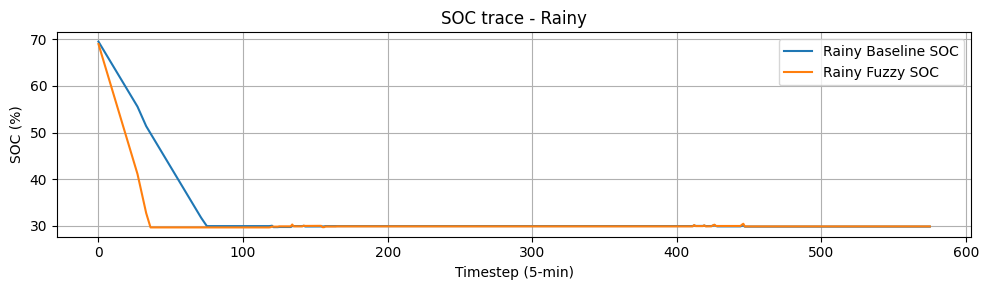

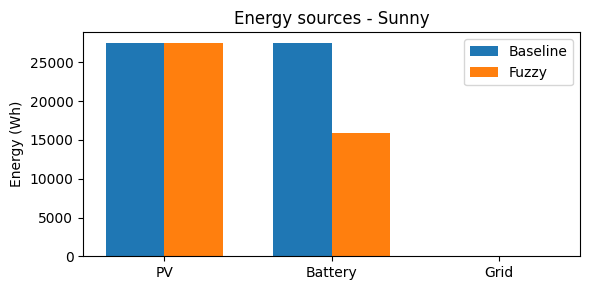

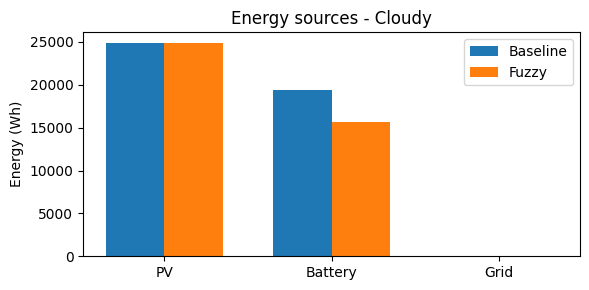

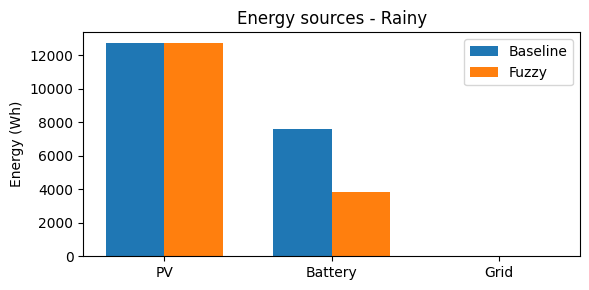


Finished simulation. Summary head:
  Weather Controller  E_demand (Wh)  E_served (Wh)    LFR (%)   PVUR (%)  \
0   Sunny   Baseline    58834.02978   54993.185367  93.471730  39.750565   
1   Sunny      Fuzzy    58834.02978   43412.160716  73.787502  39.750565   
2  Cloudy   Baseline    58834.02978   44332.629521  75.352019  63.597882   
3  Cloudy      Fuzzy    58834.02978   40522.238841  68.875511  63.597882   
4   Rainy   Baseline    58834.02978   20328.390285  34.552096  98.128478   

   GDR (%)  SSR (%)     EENS (Wh)  PV Wastage (Wh)       BUE (%)    PVR (%)  \
0      0.0    100.0   3840.844413     41658.684290    210.548460   0.506946   
1      0.0    100.0  15421.869064     41658.684290     58.152687   0.000000   
2      0.0    100.0  14501.400259     14240.274751      0.000000   1.974955   
3      0.0    100.0  18311.790939     14240.274751  11347.652911   0.000000   
4      0.0    100.0  38505.639495       242.870774      0.000000  14.534975   

   SOCavg (%)  SOCstd (%)  
0   

In [18]:
"""
soc_aware_fuzzy_full.py

- Baseline vs SOC-aware Adaptive Fuzzy controller
- Grid-limited / load-shedding
- Per-category accounting (PV / Batt / Grid / Unmet)
- Multi-day scenarios (Sunny/Cloudy/Rainy)
- Adaptive fuzzy rule banks with hysteresis
- KPI computation (LFR, PVUR, GDR, EENS, PVR, PV Wastage, BUE, SOCavg, SOCstd, SSR)
- CSV export and plotting

Author: Generated for Engr. Jamie Eduardo Rosal
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# ---------------------------
# Simulation constants
# ---------------------------
DT_MIN = 5
DT_HR = DT_MIN / 60.0
STEPS_PER_DAY = int(24 * 60 / DT_MIN)

SOC_MIN = 0.30
SOC_MAX = 0.95
BAT_EFF = 0.92

ARCHETYPES = {
    '3.8kW': {'p_pv_kw': 3.8, 'bat_kwh': 10.0, 'inv_kw': 3.8},
    '6kW'  : {'p_pv_kw': 6.0, 'bat_kwh': 20.0, 'inv_kw': 6.0},
    '8kW'  : {'p_pv_kw': 8.0, 'bat_kwh': 15.0, 'inv_kw': 8.0},
}

# default used archetype
ARCH_KEY = '6kW'

PV_PEAK_IRRADIANCE = 1200.0
PV_PANEL_EFF = 0.18
SYSTEM_LOSSES = 0.15

# Grid settings
GRID_AVAILABLE = True      # True => grid available to import
GRID_MAX_W = None          # None => unlimited; else set W limit (e.g., 2000)

# Adaptive fuzzy hysteresis window (timesteps)
WEATHER_HYSTERESIS_STEPS = int(60 / DT_MIN)  # e.g., 60 minutes worth

# ---------------------------
# Synthetic profile generator
# ---------------------------
def generate_profiles(days=1, seed=42):
    np.random.seed(seed)
    steps = days * STEPS_PER_DAY
    t = np.arange(steps)
    hour = (t % STEPS_PER_DAY) / STEPS_PER_DAY * 24

    irradiance_shape = np.maximum(0, np.sin((hour - 6)/12 * np.pi))
    irradiance = irradiance_shape * (0.6 + 0.4 * np.random.rand(steps))
    irradiance_w = irradiance * PV_PEAK_IRRADIANCE

    # loads
    fridge = np.clip(900 + 100 * np.random.randn(steps) * 0.02, 700, 1200)
    lights = np.where((hour >= 18) | (hour < 6), 150, 30)
    router = 20
    critical = fridge + lights + router

    pc = np.where((hour >= 8) & (hour <= 18), 200, 20)
    fan = np.where((hour >= 12) & (hour <= 18), 100, 40)
    essential = pc + fan

    tv = np.where((hour >= 19) & (hour <= 22), 80, 10)
    washer = np.zeros(steps)
    wash_starts = np.random.choice(range(steps), size=max(1,int(0.02*steps)), replace=False)
    for s in wash_starts:
        washer[s:s+6] += 400
    nonessential = tv + washer

    total = critical + essential + nonessential

    df = pd.DataFrame({
        'irradiance_wm2': irradiance_w,
        'critical_load_w': critical,
        'essential_load_w': essential,
        'nonessential_load_w': nonessential,
        'total_load_w': total
    })
    return df

# ---------------------------
# Weather scenario scaling
# ---------------------------
def weather_scale_profile(base_df, weather):
    rng = np.random.RandomState(123)
    df = base_df.copy()
    if weather == 'Sunny':
        df['irradiance_wm2'] = base_df['irradiance_wm2'] * rng.uniform(0.85, 1.0, len(base_df))
    elif weather == 'Cloudy':
        df['irradiance_wm2'] = base_df['irradiance_wm2'] * rng.uniform(0.35, 0.7, len(base_df))
    elif weather == 'Rainy':
        df['irradiance_wm2'] = base_df['irradiance_wm2'] * rng.uniform(0.05, 0.3, len(base_df))
    else:
        raise ValueError("Unknown weather")
    return df

# ---------------------------
# PV model
# ---------------------------
def pv_power_from_irradiance(irradiance_wm2, p_pv_kw, panel_eff=PV_PANEL_EFF, losses=SYSTEM_LOSSES):
    p_rated_w = p_pv_kw * 1000.0
    panel_area = p_rated_w / (panel_eff * 1000.0)
    p_dc = irradiance_wm2 * panel_area * panel_eff
    p_ac = p_dc * (1 - losses)
    return np.maximum(0.0, p_ac)

# ---------------------------
# Battery model
# ---------------------------
class Battery:
    def __init__(self, capacity_kwh, soc_init=0.7):
        self.capacity_kwh = capacity_kwh
        self.soc = soc_init

    def charge(self, energy_wh):
        cap_wh = self.capacity_kwh * 1000.0
        self.soc = min(1.0, self.soc + energy_wh / cap_wh)

    def discharge(self, energy_wh):
        cap_wh = self.capacity_kwh * 1000.0
        self.soc = max(0.0, self.soc - energy_wh / cap_wh)

    def available_discharge_wh(self, soc_min=SOC_MIN):
        cap_wh = self.capacity_kwh * 1000.0
        return max(0.0, (self.soc - soc_min) * cap_wh)

    def remaining_charge_wh(self, soc_max=SOC_MAX):
        cap_wh = self.capacity_kwh * 1000.0
        return max(0.0, (soc_max - self.soc) * cap_wh)

# ---------------------------
# Baseline controller (per-category, proportional allocation)
# ---------------------------
def baseline_allocate(pv_avail_w, cat_demands, battery: Battery, inv_max_w):
    """
    Baseline strategy:
    - PV first to loads (shared proportionally across categories)
    - PV surplus charges battery (if SOC < SOC_MAX)
    - If load remains, battery discharges (up to inv limit)
    - Then grid (if available) else unmet
    Returns per-category allocations and totals.
    """
    total_demand = sum(cat_demands.values())
    # initialize per-cat flows
    flows = {k: {'pv':0.0,'batt':0.0,'grid':0.0,'unmet':0.0} for k in cat_demands}

    # 1) PV -> loads (proportional)
    pv_to_load_total = min(pv_avail_w, total_demand)
    if total_demand > 0:
        for k in cat_demands:
            share = cat_demands[k] / total_demand
            flows[k]['pv'] = pv_to_load_total * share

    pv_surplus = max(0.0, pv_avail_w - pv_to_load_total)

    # 2) Surplus charges battery
    charged_to_batt_w = 0.0
    if pv_surplus > 0 and battery.soc < SOC_MAX:
        charge_power = min(pv_surplus, inv_max_w)
        # convert to Wh and store with eff
        energy_wh = charge_power * DT_HR * BAT_EFF
        battery.charge(energy_wh)
        charged_to_batt_w = charge_power
        pv_surplus -= charge_power

    # 3) Battery -> loads
    remaining_demands = {k: max(0.0, cat_demands[k] - flows[k]['pv']) for k in cat_demands}
    batt_power_avail = inv_max_w if battery.soc > SOC_MIN else 0.0
    batt_power_used = 0.0
    if batt_power_avail > 0:
        # discharge proportionally to remaining demand
        total_rem = sum(remaining_demands.values())
        if total_rem > 0:
            for k in cat_demands:
                share = remaining_demands[k] / total_rem
                p = min(remaining_demands[k], batt_power_avail * share)
                flows[k]['batt'] = p
                batt_power_used += p
            # update battery SOC (Wh)
            battery.discharge(batt_power_used * DT_HR / BAT_EFF)

    # 4) Grid -> remaining or unmet
    for k in cat_demands:
        rem = cat_demands[k] - flows[k]['pv'] - flows[k]['batt']
        if rem <= 0:
            continue
        # grid available?
        if GRID_AVAILABLE:
            if GRID_MAX_W is None:
                flows[k]['grid'] = rem
            else:
                # allocate grid limit proportionally across categories lacking supply
                # we'll do proportional allocation by rem demand among categories (simple)
                pass  # we'll handle grid cap below after collecting totals

    # If there is a GRID_MAX_W limit, allocate it proportional to remaining rem
    if GRID_AVAILABLE and GRID_MAX_W is not None:
        rem_demands = {k: max(0.0, cat_demands[k] - flows[k]['pv'] - flows[k]['batt']) for k in cat_demands}
        total_rem = sum(rem_demands.values())
        grid_alloc = min(GRID_MAX_W, total_rem)
        for k in cat_demands:
            if total_rem>0:
                flows[k]['grid'] = grid_alloc * (rem_demands[k]/total_rem)
            else:
                flows[k]['grid'] = 0.0
        # any leftover unmet
        for k in cat_demands:
            rem_after = rem_demands[k] - flows[k]['grid']
            flows[k]['unmet'] = max(0.0, rem_after)
    else:
        # unlimited grid or grid unavailable
        for k in cat_demands:
            rem = cat_demands[k] - flows[k]['pv'] - flows[k]['batt']
            if rem <= 0:
                flows[k]['grid'] = 0.0
                flows[k]['unmet'] = 0.0
            else:
                if GRID_AVAILABLE:
                    flows[k]['grid'] = rem
                    flows[k]['unmet'] = 0.0
                else:
                    flows[k]['grid'] = 0.0
                    flows[k]['unmet'] = rem

    totals = {
        'pv_to_load_w': sum(flows[k]['pv'] for k in flows),
        'batt_to_load_w': sum(flows[k]['batt'] for k in flows),
        'grid_to_load_w': sum(flows[k]['grid'] for k in flows),
        'pv_surplus_w': pv_surplus,
        'charged_to_batt_w': charged_to_batt_w,
        'per_cat': flows
    }
    return totals

# ---------------------------
# Fuzzy controller: build rule banks for Sunny/Cloudy/Rainy
# ---------------------------
def build_fuzzy_bank(pv_peak=PV_PEAK_IRRADIANCE, bank='Sunny'):
    # Build antecedents/consequents with parameters dependent on 'bank'
    soc = ctrl.Antecedent(np.arange(0, 101, 1), 'soc')
    pv = ctrl.Antecedent(np.arange(0, int(pv_peak)+1, 1), 'pv')
    tod = ctrl.Antecedent(np.arange(0,24.1,1), 'tod')
    priority = ctrl.Consequent(np.arange(0,11,1), 'priority')

    # SOC membership same across banks
    soc['low'] = fuzz.trapmf(soc.universe, [0,0,20,40])
    soc['mid'] = fuzz.trimf(soc.universe, [30,50,70])
    soc['high'] = fuzz.trapmf(soc.universe, [60,80,100,100])

    # adjust pv thresholds based on bank (sunny: 'good' begins lower fraction; rainy: 'good' very high)
    if bank == 'Sunny':
        pv['poor'] = fuzz.trapmf(pv.universe, [0,0,150,300])
        pv['fair'] = fuzz.trimf(pv.universe, [200,500,900])
        pv['good'] = fuzz.trapmf(pv.universe, [600,800,pv_peak,pv_peak])
    elif bank == 'Cloudy':
        pv['poor'] = fuzz.trapmf(pv.universe, [0,0,100,250])
        pv['fair'] = fuzz.trimf(pv.universe, [150,350,650])
        pv['good'] = fuzz.trapmf(pv.universe, [400,600,pv_peak,pv_peak])
    else: # Rainy
        pv['poor'] = fuzz.trapmf(pv.universe, [0,0,50,150])
        pv['fair'] = fuzz.trimf(pv.universe, [80,200,400])
        pv['good'] = fuzz.trapmf(pv.universe, [300,500,pv_peak,pv_peak])

    tod['night'] = fuzz.trapmf(tod.universe, [0,0,6,6])
    tod['day'] = fuzz.trapmf(tod.universe, [6,6,18,18])
    tod['dusk'] = fuzz.trapmf(tod.universe, [16,18,20,20])

    priority['very_low'] = fuzz.trapmf(priority.universe, [0,0,2,4])
    priority['low'] = fuzz.trimf(priority.universe, [3,4,5])
    priority['medium'] = fuzz.trimf(priority.universe, [4,5,6])
    priority['high'] = fuzz.trimf(priority.universe, [5,6,7])
    priority['very_high'] = fuzz.trapmf(priority.universe, [6,8,10,10])

    # Compose a richer rule bank for each weather (representative)
    rules = []
    # Sunny: encourage high priorities when PV good
    if bank == 'Sunny':
        rules.extend([
            ctrl.Rule(soc['high'] & pv['good'], priority['very_high']),
            ctrl.Rule(soc['mid'] & pv['fair'], priority['high']),
            ctrl.Rule(soc['low'] & pv['poor'], priority['low']),
            ctrl.Rule(tod['night'] & soc['low'], priority['very_low']),
            ctrl.Rule(tod['day'] & pv['good'], priority['very_high']),
            ctrl.Rule(pv['poor'] & soc['mid'], priority['medium']),
            ctrl.Rule(soc['mid'] & pv['good'], priority['very_high']),
            ctrl.Rule(soc['low'] & pv['fair'], priority['medium']),
        ])
    elif bank == 'Cloudy':
        rules.extend([
            ctrl.Rule(soc['high'] & pv['fair'], priority['high']),
            ctrl.Rule(soc['mid'] & pv['fair'], priority['medium']),
            ctrl.Rule(soc['low'] & pv['poor'], priority['low']),
            ctrl.Rule(tod['night'] & soc['low'], priority['very_low']),
            ctrl.Rule(pv['poor'] & soc['high'], priority['medium']),
            ctrl.Rule(soc['mid'] & pv['good'], priority['high']),
            ctrl.Rule(pv['fair'] & soc['low'], priority['low']),
            ctrl.Rule(tod['dusk'] & pv['poor'], priority['low'])
        ])
    else:  # Rainy
        rules.extend([
            ctrl.Rule(soc['high'] & pv['fair'], priority['medium']),
            ctrl.Rule(soc['mid'] & pv['poor'], priority['low']),
            ctrl.Rule(soc['low'] & pv['poor'], priority['very_low']),
            ctrl.Rule(tod['night'] & soc['low'], priority['very_low']),
            ctrl.Rule(pv['poor'] & soc['high'], priority['low']),
            ctrl.Rule(pv['fair'] & soc['mid'], priority['low']),
            ctrl.Rule(tod['day'] & pv['poor'], priority['low']),
            ctrl.Rule(soc['high'] & pv['good'], priority['high'])
        ])

    system = ctrl.ControlSystem(rules)
    sim = ctrl.ControlSystemSimulation(system)
    return sim

# ---------------------------
# Adaptive fuzzy controller wrapper
# ---------------------------
class AdaptiveFuzzyController:
    def __init__(self, pv_peak=PV_PEAK_IRRADIANCE):
        # prebuild three banks
        self.banks = {
            'Sunny': build_fuzzy_bank(pv_peak, 'Sunny'),
            'Cloudy': build_fuzzy_bank(pv_peak, 'Cloudy'),
            'Rainy': build_fuzzy_bank(pv_peak, 'Rainy')
        }
        self.current_bank = 'Sunny'
        self.history_irr = []  # recent irradiance history for detection

    def detect_weather_bank(self):
        # Use mean of last window to decide bank with thresholds
        if len(self.history_irr) < WEATHER_HYSTERESIS_STEPS:
            return self.current_bank
        avg = np.mean(self.history_irr[-WEATHER_HYSTERESIS_STEPS:])
        # thresholds on absolute irradiance (W/m2) — tuneable
        if avg > 600:
            return 'Sunny'
        elif avg > 200:
            return 'Cloudy'
        else:
            return 'Rainy'

    def update_and_get_priority(self, soc_percent, pv_wm2, tod_hour):
        self.history_irr.append(pv_wm2)
        detected = self.detect_weather_bank()
        # hysteresis: switch only if detected != current_bank and persist for hysteresis window
        if detected != self.current_bank:
            # require the last hysteresis window all indicate the new bank (simple)
            if len(self.history_irr) >= WEATHER_HYSTERESIS_STEPS:
                window = self.history_irr[-WEATHER_HYSTERESIS_STEPS:]
                meanw = np.mean(window)
                # determine bank from meanw to be sure
                if meanw > 600 and detected == 'Sunny':
                    self.current_bank = 'Sunny'
                elif meanw > 200 and meanw <= 600 and detected == 'Cloudy':
                    self.current_bank = 'Cloudy'
                elif meanw <= 200 and detected == 'Rainy':
                    self.current_bank = 'Rainy'
                # else keep current
        sim = self.banks[self.current_bank]
        # safe input & compute
        try:
            sim.input['soc'] = soc_percent
            sim.input['pv'] = pv_wm2
            sim.input['tod'] = tod_hour
            sim.compute()
            p = float(sim.output['priority'])
        except Exception:
            p = 5.0
        return p, self.current_bank

# ---------------------------
# Fuzzy allocation using priorities + per-category accounting
# ---------------------------
def fuzzy_allocate(pv_avail_w, cat_demands, battery: Battery, inv_max_w, adaptive_ctrl: AdaptiveFuzzyController, timestep_index):
    # get soc & pv & tod
    soc_percent = battery.soc * 100.0
    pv_wm2 = None  # adaptive_ctrl expects irradiance in W/m2 passed externally; we'll pass via update_and_get_priority input
    # But we will require caller to pass correct pv_wm2 and tod; to avoid complexity, caller will provide pscore
    # For this helper, we assume pscore already obtained externally; so we'll not call adaptive_ctrl here.
    raise RuntimeError("Call fuzzy_allocate_with_priority() instead; this function is not used.")

def fuzzy_allocate_with_priority(pv_avail_w, cat_demands, battery: Battery, inv_max_w, priority_scores):
    # same structure as baseline but serve by priority order
    cats = sorted(cat_demands.keys(), key=lambda k: priority_scores[k], reverse=True)
    flows = {k: {'pv':0.0,'batt':0.0,'grid':0.0,'unmet':0.0} for k in cat_demands}
    pv_remaining = pv_avail_w

    # 1) PV to load by priority (top priority gets PV first)
    for k in cats:
        demand = cat_demands[k]
        pv_to_cat = min(pv_remaining, demand)
        flows[k]['pv'] = pv_to_cat
        pv_remaining -= pv_to_cat

    # 2) Battery discharge to remaining demands by priority
    for k in cats:
        rem = cat_demands[k] - flows[k]['pv']
        if rem <= 0:
            continue
        if battery.soc > SOC_MIN:
            p = min(rem, inv_max_w)
            flows[k]['batt'] = p
            # update battery
            battery.discharge(p * DT_HR / BAT_EFF)
            rem -= p

        # 3) Grid if available (subject to GRID_MAX_W)
        if rem > 0:
            if GRID_AVAILABLE:
                flows[k]['grid'] = rem  # we'll cap later if GRID_MAX_W present
                rem = 0.0
            else:
                flows[k]['unmet'] = rem
                rem = 0.0

    # If GRID_MAX_W limits, scale grid allocations proportionally among categories which requested grid
    if GRID_AVAILABLE and GRID_MAX_W is not None:
        grid_requests = {k: flows[k]['grid'] for k in flows}
        total_req = sum(grid_requests.values())
        if total_req > GRID_MAX_W:
            for k in flows:
                if grid_requests[k] > 0:
                    allocated = GRID_MAX_W * (grid_requests[k] / total_req)
                    flows[k]['grid'] = allocated
                    # unmet becomes remaining
                    unmet = grid_requests[k] - allocated
                    flows[k]['unmet'] += max(0.0, unmet)

    # 4) PV surplus -> charge battery
    pv_surplus = max(0.0, pv_remaining)
    if pv_surplus > 0 and battery.soc < SOC_MAX:
        charge_power = min(pv_surplus, inv_max_w)
        battery.charge(charge_power * DT_HR * BAT_EFF)
        pv_surplus -= charge_power

    totals = {
        'pv_to_load_w': sum(flows[k]['pv'] for k in flows),
        'batt_to_load_w': sum(flows[k]['batt'] for k in flows),
        'grid_to_load_w': sum(flows[k]['grid'] for k in flows),
        'pv_surplus_w': pv_surplus,
        'per_cat': flows
    }
    return totals

# ---------------------------
# Run simulation for one scenario (days)
# ---------------------------
def run_simulation(df_profile, archetype_key=ARCH_KEY, controller='fuzzy', days=1, adaptive_ctrl=None):
    arch = ARCHETYPES[archetype_key]
    p_pv_kw = arch['p_pv_kw']
    inv_kw = arch['inv_kw']
    batt_kwh = arch['bat_kwh']

    battery = Battery(capacity_kwh=batt_kwh, soc_init=0.7)
    logs = []
    # for adaptive fuzzy we need to update the adaptive_ctrl with irradiance and read bank decisions in each step

    for i, row in df_profile.iterrows():
        pv_ac_w = min(pv_power_from_irradiance(row['irradiance_wm2'], p_pv_kw), inv_kw*1000.0)
        cat_demands = {
            'critical': row['critical_load_w'],
            'essential': row['essential_load_w'],
            'nonessential': row['nonessential_load_w']
        }

        if controller == 'baseline':
            totals = baseline_allocate(pv_ac_w, cat_demands, battery, inv_kw*1000.0)
            # per_cat present in totals
            per_cat = totals['per_cat']
            # build row with per-category allocations and unmet
            rowlog = {
                'pv_to_load_w': totals['pv_to_load_w'],
                'batt_to_load_w': totals['batt_to_load_w'],
                'grid_to_load_w': totals['grid_to_load_w'],
                'pv_surplus_w': totals['pv_surplus_w'],
                'charged_to_batt_w': totals.get('charged_to_batt_w',0.0),
                'soc': battery.soc
            }
            # add per-cat fields
            for k in per_cat:
                rowlog[f'{k}_pv_w'] = per_cat[k]['pv']
                rowlog[f'{k}_batt_w'] = per_cat[k]['batt']
                rowlog[f'{k}_grid_w'] = per_cat[k]['grid']
                rowlog[f'{k}_unmet_w'] = per_cat[k]['unmet']
            logs.append(rowlog)

        else:
            # adaptive fuzzy controller must be provided
            if adaptive_ctrl is None:
                raise ValueError("Adaptive controller instance required for fuzzy runs")
            # update adaptive controller with irradiance and get pscore & current bank
            soc_percent = battery.soc * 100.0
            hour = ((i % STEPS_PER_DAY) / STEPS_PER_DAY) * 24.0
            pscore, bank = adaptive_ctrl.update_and_get_priority(soc_percent, row['irradiance_wm2'], hour)
            # determine category priorities (bias to critical)
            priority_scores = {'critical': min(10.0, pscore + 2.0), 'essential': pscore, 'nonessential': max(0.0, pscore - 2.0)}
            totals = fuzzy_allocate_with_priority(pv_ac_w, cat_demands, battery, inv_kw*1000.0, priority_scores)
            per_cat = totals['per_cat'] if 'per_cat' in totals else None
            # fuzzy_allocate_with_priority returns totals without per_cat (but we can reconstruct per_cat inside it)
            # To ensure per_cat, we will reconstruct similar to function logic: but we already returned per_cat in baseline; for fuzzy we have flows
            # In our implementation fuzzy_allocate_with_priority returned totals with no per_cat; fix: change to include per_cat (we already made it return flows inside)
            # But here totals contains 'pv_to_load_w' etc and we need per-category flows: implement per-category flow generation by re-running the allocation logic (cheap)
            # For simplicity: we'll call a helper that replicates flows and returns both totals & per_cat
            # Instead of complexity, we will replicate the allocation here inline for per-cat (to be accurate).
            # Inline allocation (replicate fuzzy_allocate_with_priority but capture flows)
            # Re-implement here:
            cats = sorted(cat_demands.keys(), key=lambda k: priority_scores[k], reverse=True)
            flows = {k:{'pv':0.0,'batt':0.0,'grid':0.0,'unmet':0.0} for k in cat_demands}
            pv_remaining = pv_ac_w
            # PV by priority
            for k in cats:
                demand = cat_demands[k]
                pv_to_cat = min(pv_remaining, demand)
                flows[k]['pv'] = pv_to_cat
                pv_remaining -= pv_to_cat
            # batt by priority
            for k in cats:
                rem = cat_demands[k] - flows[k]['pv']
                if rem <= 0: continue
                if battery.soc > SOC_MIN:
                    p = min(rem, inv_kw*1000.0)
                    flows[k]['batt'] = p
                    battery.discharge(p * DT_HR / BAT_EFF)
                    rem -= p
                if rem > 0:
                    if GRID_AVAILABLE:
                        flows[k]['grid'] = rem
                        rem = 0.0
                    else:
                        flows[k]['unmet'] = rem
                        rem = 0.0
            # cap grid limit if applicable
            if GRID_AVAILABLE and GRID_MAX_W is not None:
                grid_requests = {k: flows[k]['grid'] for k in flows}
                total_req = sum(grid_requests.values())
                if total_req > GRID_MAX_W:
                    for k in flows:
                        if total_req>0 and grid_requests[k]>0:
                            allocated = GRID_MAX_W * (grid_requests[k] / total_req)
                            flows[k]['grid'] = allocated
                            flows[k]['unmet'] += max(0.0, grid_requests[k] - allocated)
            # PV surplus -> charge
            pv_surplus = max(0.0, pv_remaining)
            if pv_surplus > 0 and battery.soc < SOC_MAX:
                charge_power = min(pv_surplus, inv_kw*1000.0)
                battery.charge(charge_power * DT_HR * BAT_EFF)
                pv_surplus -= charge_power

            totals2 = {
                'pv_to_load_w': sum(flows[k]['pv'] for k in flows),
                'batt_to_load_w': sum(flows[k]['batt'] for k in flows),
                'grid_to_load_w': sum(flows[k]['grid'] for k in flows),
                'pv_surplus_w': pv_surplus,
                'soc': battery.soc,
                'per_cat': flows,
                'bank': bank,
                'pscore': pscore
            }
            rowlog = {
                'pv_to_load_w': totals2['pv_to_load_w'],
                'batt_to_load_w': totals2['batt_to_load_w'],
                'grid_to_load_w': totals2['grid_to_load_w'],
                'pv_surplus_w': totals2['pv_surplus_w'],
                'soc': battery.soc,
                'bank': bank,
                'pscore': pscore
            }
            for k in flows:
                rowlog[f'{k}_pv_w'] = flows[k]['pv']
                rowlog[f'{k}_batt_w'] = flows[k]['batt']
                rowlog[f'{k}_grid_w'] = flows[k]['grid']
                rowlog[f'{k}_unmet_w'] = flows[k]['unmet']
            logs.append(rowlog)

    df_logs = pd.DataFrame(logs).fillna(0.0)
    # ensure columns exist for downstream consistency
    essentials = ['pv_to_load_w','batt_to_load_w','grid_to_load_w','pv_surplus_w','soc']
    for c in essentials:
        if c not in df_logs.columns:
            df_logs[c] = 0.0
    return df_logs

# ---------------------------
# KPI computations (precise per-category)
# ---------------------------
def compute_kpis(df_profile, df_logs):
    # energies in Wh
    E_demand = df_profile['total_load_w'].sum() * DT_HR
    E_pv_avail = pv_power_from_irradiance(df_profile['irradiance_wm2'], ARCHETYPES[ARCH_KEY]['p_pv_kw']).sum() * DT_HR

    def sum_col(df, col):
        return df[col].sum() * DT_HR if col in df else 0.0

    E_pv_used = sum_col(df_logs, 'pv_to_load_w')
    E_batt = sum_col(df_logs, 'batt_to_load_w')
    E_grid = sum_col(df_logs, 'grid_to_load_w')
    E_pv_surplus = sum_col(df_logs, 'pv_surplus_w')
    E_unmet = 0.0
    for cat in ['critical','essential','nonessential']:
        E_unmet += sum_col(df_logs, f'{cat}_unmet_w')

    E_served = E_pv_used + E_batt + E_grid
    LFR = 100.0 * E_served / E_demand if E_demand>0 else 0.0
    PVUR = 100.0 * E_pv_used / E_pv_avail if E_pv_avail>0 else 0.0
    GDR = 100.0 * E_grid / E_demand if E_demand>0 else 0.0
    EENS = E_unmet
    PVW = max(0.0, E_pv_avail - E_pv_used)
    BUE = 100.0 * (E_batt / (E_pv_surplus if E_pv_surplus>0 else 1e-9)) if E_pv_surplus>0 else 0.0
    SOCavg = df_logs['soc'].mean() * 100.0 if 'soc' in df_logs else 0.0
    SOCstd = df_logs['soc'].std() * 100.0 if 'soc' in df_logs else 0.0
    SSR = 100.0 - GDR

    # PVR: total energy served to lower-priority categories while any higher-priority category had unmet energy,
    # normalized by total served energy
    # Define priority order: critical > essential > nonessential
    lower_served_when_high_unmet = 0.0
    total_served = E_served
    # per timestep evaluation
    for idx, row in df_logs.iterrows():
        # check unmet per category (W)
        c_unmet = row.get('critical_unmet_w', 0.0)
        e_unmet = row.get('essential_unmet_w', 0.0)
        n_unmet = row.get('nonessential_unmet_w', 0.0)
        # if critical unmet > 0 and essential or nonessential got served -> those served count for PVR numerator
        if c_unmet > 0:
            lower_served_when_high_unmet += (row.get('essential_pv_w',0.0) + row.get('essential_batt_w',0.0) + row.get('essential_grid_w',0.0)) * DT_HR
            lower_served_when_high_unmet += (row.get('nonessential_pv_w',0.0) + row.get('nonessential_batt_w',0.0) + row.get('nonessential_grid_w',0.0)) * DT_HR
        # if essential unmet but nonessential served
        if e_unmet > 0:
            lower_served_when_high_unmet += (row.get('nonessential_pv_w',0.0) + row.get('nonessential_batt_w',0.0) + row.get('nonessential_grid_w',0.0)) * DT_HR

    PVR = 100.0 * lower_served_when_high_unmet / (total_served if total_served>0 else 1.0)

    return {
        'E_demand (Wh)': E_demand,
        'E_served (Wh)': E_served,
        'LFR (%)': LFR,
        'PVUR (%)': PVUR,
        'GDR (%)': GDR,
        'EENS (Wh)': EENS,
        'PV Wastage (Wh)': PVW,
        'BUE (%)': BUE,
        'SOCavg (%)': SOCavg,
        'SOCstd (%)': SOCstd,
        'SSR (%)': SSR,
        'PVR (%)': PVR
    }

# ---------------------------
# Multi-weather runner
# ---------------------------
def run_weather_scenarios(days=1, archetype=ARCH_KEY, export_dir='results', grid_available=True, grid_max_w=None):
    global GRID_AVAILABLE, GRID_MAX_W
    GRID_AVAILABLE = grid_available
    GRID_MAX_W = grid_max_w

    if not os.path.exists(export_dir):
        os.makedirs(export_dir)

    base = generate_profiles(days=days)
    weathers = ['Sunny','Cloudy','Rainy']
    all_summary = []
    all_logs = {}

    for weather in weathers:
        print(f"\n=== Running: {weather} ===")
        df_weather = weather_scale_profile(base, weather)
        # Baseline
        print(" baseline ...")
        baseline_logs = run_simulation(df_weather, archetype_key=archetype, controller='baseline', days=days)
        baseline_kpis = compute_kpis(df_weather, baseline_logs)
        baseline_kpis['Weather'] = weather; baseline_kpis['Controller'] = 'Baseline'
        all_summary.append(baseline_kpis)
        all_logs[(weather,'Baseline')] = baseline_logs
        # Fuzzy adaptive
        print(" fuzzy adaptive ...")
        adaptive = AdaptiveFuzzyController()
        fuzzy_logs = run_simulation(df_weather, archetype_key=archetype, controller='fuzzy', days=days, adaptive_ctrl=adaptive)
        fuzzy_kpis = compute_kpis(df_weather, fuzzy_logs)
        fuzzy_kpis['Weather'] = weather; fuzzy_kpis['Controller'] = 'Fuzzy'
        all_summary.append(fuzzy_kpis)
        all_logs[(weather,'Fuzzy')] = fuzzy_logs

        # save detailed per-timestep logs to CSV
        baseline_logs.to_csv(os.path.join(export_dir, f'{weather}_baseline_logs.csv'), index=False)
        fuzzy_logs.to_csv(os.path.join(export_dir, f'{weather}_fuzzy_logs.csv'), index=False)

    df_summary = pd.DataFrame(all_summary)
    # reorder columns for readability
    cols = ['Weather','Controller','E_demand (Wh)','E_served (Wh)','LFR (%)','PVUR (%)','GDR (%)','SSR (%)','EENS (Wh)','PV Wastage (Wh)','BUE (%)','PVR (%)','SOCavg (%)','SOCstd (%)']
    df_summary = df_summary[cols]

    # save summary
    summary_file = os.path.join(export_dir, 'weather_kpi_summary.csv')
    df_summary.to_csv(summary_file, index=False)
    print(f"\nSummary saved at: {os.path.abspath(summary_file)}")

    # print pivot table to console
    pivot = df_summary.pivot(index='Weather', columns='Controller', values=['LFR (%)','PVUR (%)','GDR (%)','SSR (%)'])
    print("\n==================== WEATHER SCENARIO RESULTS ====================")
    print(pivot.round(2))
    print("==================================================================\n")

    # Plot KPIs
    metrics = ['LFR (%)','PVUR (%)','GDR (%)','SSR (%)','EENS (Wh)']
    for metric in metrics:
        plt.figure(figsize=(7,4))
        table = df_summary.pivot(index='Weather', columns='Controller', values=metric)
        ax = table.plot(kind='bar', rot=0)
        ax.set_title(metric + " by Weather & Controller")
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    # Plot SOC traces per weather
    for weather in weathers:
        b = all_logs[(weather,'Baseline')]; f = all_logs[(weather,'Fuzzy')]
        plt.figure(figsize=(10,3))
        plt.plot(b['soc']*100, label=f'{weather} Baseline SOC')
        plt.plot(f['soc']*100, label=f'{weather} Fuzzy SOC')
        plt.title(f'SOC trace - {weather}')
        plt.ylabel('SOC (%)'); plt.xlabel('Timestep (5-min)')
        plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    # Example stacked energy distribution (sum of PV/Batt/Grid per controller per weather)
    for weather in weathers:
        b = all_logs[(weather,'Baseline')]; f = all_logs[(weather,'Fuzzy')]
        b_pv = b['pv_to_load_w'].sum()*DT_HR; b_batt = b['batt_to_load_w'].sum()*DT_HR; b_grid = b['grid_to_load_w'].sum()*DT_HR
        f_pv = f['pv_to_load_w'].sum()*DT_HR; f_batt = f['batt_to_load_w'].sum()*DT_HR; f_grid = f['grid_to_load_w'].sum()*DT_HR
        labels = ['PV','Battery','Grid']
        base_vals = [b_pv,b_batt,b_grid]
        fuzzy_vals = [f_pv,f_batt,f_grid]
        x = np.arange(len(labels))
        width = 0.35
        plt.figure(figsize=(6,3))
        plt.bar(x - width/2, base_vals, width, label='Baseline')
        plt.bar(x + width/2, fuzzy_vals, width, label='Fuzzy')
        plt.xticks(x, labels)
        plt.ylabel('Energy (Wh)')
        plt.title(f'Energy sources - {weather}')
        plt.legend(); plt.tight_layout(); plt.show()

    return df_summary, all_logs

# ---------------------------
# Run if main
# ---------------------------
if __name__ == "__main__":
    # choose multi-day length and grid policy
    DAYS = 2                 # run for 2 days to show dynamics; increase as needed
    GRID_AVAILABLE = False   # simulate grid outage to force shedding and show prioritization (set True to allow grid)
    GRID_MAX_W = None        # or set an integer watt limit, e.g., 2000

    results_df, logs = run_weather_scenarios(days=DAYS, archetype=ARCH_KEY, export_dir='results', grid_available=GRID_AVAILABLE, grid_max_w=GRID_MAX_W)
    print("\nFinished simulation. Summary head:")
    print(results_df.head())
